<a href="https://colab.research.google.com/github/fendy07/chatbot-AI/blob/master/DL_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

Tahapan pertama sebelum melakukan eksplorasi dan praproses pada data adalah memasukan library yang akan digunakan untuk menganalisa dataset dengan menggunakan metode Deep Learning seperti Neural Network dalam pengolahan teks, Chatbot dll. Library yang saya gunakan yaitu NumPy untuk komputasi matematika, Matplotlib untuk visualisasi model data, Natural Language Toolkit atau NLTK untuk pengolahan teks, Pandas untuk membaca data, serta Tensorflow untuk model pada data menggunakan algoritma LSTM dan Jaringan Syaraf Tiruan (Neural Network).

In [1]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

## **Download NLTK Package**

In [2]:
# Package sentence tokenizer
nltk.download('punkt') 
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fawza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fawza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fawza\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# **Load Dataset Json**

In [3]:
# Importing the dataset
with open('intents.json', 'r', encoding='utf-8') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [4]:
# Cetak data keseluruhan
data 

,patterns,tags
0,"saya memiliki masalah sengketa harta waris, ba...",gugatan_waris_sengketa_harta
1,bagaimana proses masalah sengketa waris?,gugatan_waris_sengketa_harta
2,proses sengketa harta waris,gugatan_waris_sengketa_harta
3,proses sengketa waris,gugatan_waris_sengketa_harta
4,sengketa harta waris,gugatan_waris_sengketa_harta
...,...,...
1694,Berapa tarif perkara gugatan kelompok?,kelompok_tarif
1695,tarif gugatan kelompok,kelompok_tarif
1696,gugatan kelompok bayar berapa,kelompok_tarif
1697,biaya gugatan kelompok,kelompok_tarif


In [5]:
# Cetak data baris pertama sampai baris kelima
data.head() 

,patterns,tags
0,"saya memiliki masalah sengketa harta waris, ba...",gugatan_waris_sengketa_harta
1,bagaimana proses masalah sengketa waris?,gugatan_waris_sengketa_harta
2,proses sengketa harta waris,gugatan_waris_sengketa_harta
3,proses sengketa waris,gugatan_waris_sengketa_harta
4,sengketa harta waris,gugatan_waris_sengketa_harta


In [6]:
# Cetak data baris ke-70 sampai baris akhir
data.tail() 

,patterns,tags
1694,Berapa tarif perkara gugatan kelompok?,kelompok_tarif
1695,tarif gugatan kelompok,kelompok_tarif
1696,gugatan kelompok bayar berapa,kelompok_tarif
1697,biaya gugatan kelompok,kelompok_tarif
1698,saya harus membayar biaya berapa untuk mengaju...,kelompok_tarif


Data yang telah kita miliki dalam format JSON yang dapat digunakan melalui pandas dengan cara konversi. Data JSON yang saya miliki didapat dengan cara manual dengan mengambil beberapa referensi website tentang program Kampus Merdeka.

# **Preprocessing The Data**

Setelah kita meload data dan mengonversi data json menjadi dataframe. Tahapan selanjutnya adalah praproses pada dataset yang kita gunakan saat ini yaitu dengan cara:

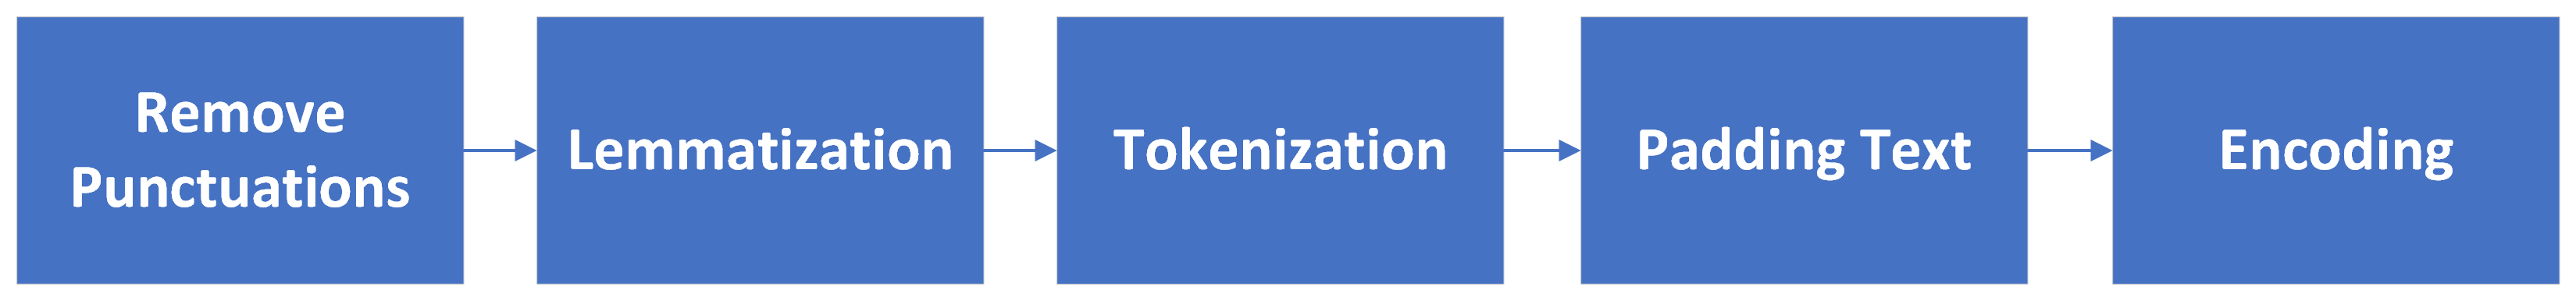

1.   Remove Punctuations (Menghapus Punktuasi)
2.   Lematization (Lematisasi)
3.   Tokenization (Tokenisasi)
4.   Apply Padding (Padding)
5.   Encoding the Outputs (Konversi Keluaran Enkoding)

Kelima tahapan pemrosesan teks ini dijelaskan pada bagian langkah selanjutnya.

## **Remove Punctuations**

Tahapan praproses pada data teks yang pertama adalah menghapus punktuasi atau tanda baca seperti *special character* yaitu **'!'** (**tanda seru**) **','** (**tanda koma**) **'.'** (**tanda titik sebagai berhenti**) '**?**' (**tanda tanya**) dan tanda baca yang lain. Tahapan ini gunanya untuk mempermudah pemrosesan data teks yang akan kita olah.

In [7]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

## **Lemmatization (Lematisasi)**

Setelah menghapus punktuasi atau tanda baca, tahapan selanjutnya yaitu Lematisasi atau Lemmatization. **Apa itu Lematisasi?**

Lematisasi atau Lemmatization adalah proses dimana merujuk pada melakukan sesuatu menggunakan vocabulary atau kosakata dan analisis morfologi kata-kata untuk menghilangkan *inflectional endings only* dan untuk mengembalikan bentuk *dictionary* (kata dalam kamus) dari sebuah kata yang dikenal sebagai ***lemma***. 

Contoh Lematisasi : **Menggunakan** (Kata Imbuhan) -> **Guna** (Kata Dasar) 

Dalam contoh berikut proses lematisasi awalnya data teks menggunakan kata imbuhan yaitu **Menggunakan** dimana **meng-** + **guna** (kata dasar yang berawalan vokal g) + **kan** (sebagai akhiran) diubah menjadi kata dasar yaitu '**Guna**'. 

Proses ini dimana menghilangkan Prefiks pada imbuhan (**Meng-**) dan Suffiks pada (**-kan**).

In [8]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

919 unique lemmatized words ['(', ')', ',', '.', '1', '18', '200', '21', 'a', 'acara', 'account', 'action', 'ada', 'adakah', 'adanya', 'adhal', 'adhol', 'adil', 'administrasi', 'agama', 'agar', 'ahli', 'ak', 'akad', 'akan', 'akibat', 'akibatnya', 'akrena', 'akta', 'aktivasi', 'akun', 'alasan', 'alih', 'alur', 'aman', 'amil', 'anak', 'anak-anak', 'angkat', 'angsuran', 'antara', 'apa', 'apabila', 'apakah', 'aplikasi', 'asal', 'aset', 'aspek', 'asuh', 'asuransi', 'atas', 'atau', 'aturan', 'b', 'ba', 'bagaimana', 'bagaimanan', 'bagi', 'bagian', 'baginya', 'bahwa', 'balasan', 'balik', 'banding', 'bandung', 'bangunan', 'bank', 'bantuan', 'banyak', 'bata', 'batal', 'batasan', 'batasannya', 'bawa', 'bawah', 'bayar', 'bayi', 'bebas', 'beberapa', 'beda', 'bedanya', 'belum', 'benar', 'benda', 'benda-benda', 'bentuk', 'berada', 'berapa', 'berapakah', 'berbagai', 'berbatas', 'berbeda', 'bercerai', 'berdasarkan', 'bereskan', 'berfokus', 'bergantung', 'bergerak', 'berhak', 'berisbat', 'beristri', 'be

### **Menyortir Data Kelas Tags**

In [9]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

241 classes ['administrasi_sidang_biaya_perkara', 'administrasi_sidang_hak_persidangan', 'administrasi_sidang_hitung_perkara', 'administrasi_sidang_panjar_habis', 'administrasi_sidang_persyaratan', 'administrasi_sidang_pertimbangan_panjar', 'aduan_layanan_prosedur', 'ecourt_batas_waktu_bayar', 'ecourt_bayar', 'ecourt_bayar_titip', 'ecourt_call_center', 'ecourt_daftar_tanpa_email', 'ecourt_data', 'ecourt_definisi', 'ecourt_dokumen_daftar_perkara', 'ecourt_e-filling', 'ecourt_e-litigation', 'ecourt_e-payment', 'ecourt_e-summons', 'ecourt_edit_dokumen', 'ecourt_email_aktivasi', 'ecourt_info_sisa_panjar', 'ecourt_info_tambahan_panjar', 'ecourt_konfirmasi_salah_bayar', 'ecourt_kredit', 'ecourt_kuasa_lebih_dari_satu', 'ecourt_layanan', 'ecourt_legal_daftar', 'ecourt_non_advokat', 'ecourt_panggilan_elektronik_biaya', 'ecourt_panggilan_elektronik_email', 'ecourt_panggilan_luar_negeri', 'ecourt_panggilan_pertama_tergugat', 'ecourt_pembayaran_bank', 'ecourt_pemula', 'ecourt_pengajuan_online', 'e

### **Mencari Jumlah Keseluruhan Data Teks**

In [10]:
# documents = combination between patterns and intents
print (len(documents), "documents")

36605 documents


## **Tokenization (Tokenisasi)**

Setelah proses lematisasi dan mencari tahu data classes dan jumlah keseluruhan data patterns dengan intents-nya. Maka, tahapan selanjutnya proses tokenisasi. **Apa itu Tokenisasi?**

Tokenisasi adalah suatu proses memberikan urutan karakter dan sebuah unit dokumen terdefinisi. Tokenisasi juga merupakan tugas untuk memecah kalimat menjadi bagian-bagian yang disebut dengan '**Token**' dan menghilangkan bagian tertentu seperti tanda baca.

Contohnya: **Aku Pergi Ke Makassar** -> '**Aku**' '**Pergi**' '**Ke**' '**Makassar**'

In [11]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[2, 59, 263, 25, 19, 24, 9, 624, 625],
 [9, 85, 263, 25, 24],
 [85, 25, 19, 24],
 [85, 25, 24],
 [25, 19, 24],
 [25, 24],
 [263, 19, 24],
 [9, 33, 103, 25, 31, 24, 1, 490, 190, 36, 236, 301, 626],
 [25, 31, 24, 214, 236],
 [25, 31, 24, 490, 627],
 [9, 15, 17, 25, 31, 24, 264, 628, 14, 35, 236, 1, 190],
 [25, 31, 24, 214, 629],
 [25, 31, 24, 214, 236],
 [25, 31, 24, 236, 190],
 [25, 31, 24, 35, 236, 1, 190],
 [25, 31, 214, 236],
 [9, 33, 2, 630, 131, 36, 156, 138, 24],
 [131, 156, 24],
 [131, 156, 302, 303, 24],
 [131, 138, 24],
 [131, 302, 303, 24],
 [3, 2, 346, 104, 29, 119, 47, 4, 79, 34],
 [34, 346, 176, 104, 29, 119, 47],
 [105, 176, 104, 29, 119, 47, 4, 34],
 [3, 105, 176, 104, 29, 119, 47, 4, 34],
 [191, 17, 34, 80, 48, 176, 104, 29, 119, 47],
 [34, 80, 176, 104, 29, 119, 47],
 [9, 46, 34, 157, 106, 1, 631, 176, 124, 138, 347],
 [46, 34, 132, 413, 176],
 [46, 34, 157, 176, 413, 124, 138, 347],
 [413, 176, 124, 138, 347],
 [46, 132, 632, 176, 124, 138, 347],
 [33, 28, 34, 95, 177

## **Padding**

Setelah memproses tokenisasi yang dimana memecah kalimat menajdi bagian-bagian yang disebut token yang digunakan untuk mengolah data teks pada AI Chatbot maka tahapan selanjutnya adalah Padding.
**Apa itu Padding?**

**Padding** adalah Suatu proses untuk mengubah setiap sequence agar memiliki panjang yang sama. Pada padding, setiap sequence dibuat sama panjang dengan menambahkan nilai 0 secara suffiks atau prefiks hingga mencapai panjang maksimum sequence. Selain itu padding juga dapat memotong sequence hingga panjangnya sesuai dengan panjang maksimum sequence. 

Padding juga adalah proses untuk membuat setiap kalimat pada teks memiliki panjang yang seragam. Sama seperti melakukan resize gambar, agar resolusi setiap gambar sama besar. Untuk menggunakan padding bisa impor library **pad_sequence**. Kemudian buat panggil fungsi pad_sequence() dan masukkan sequence hasil tokenisasi sebagai parameternya.

Contohnya: `sequences_samapanjang = pad_sequences(sequences)`

Yang nantinya akan dikeluarkan menjadi angka dengan awalan 0 seperti gambar dibawah ini.

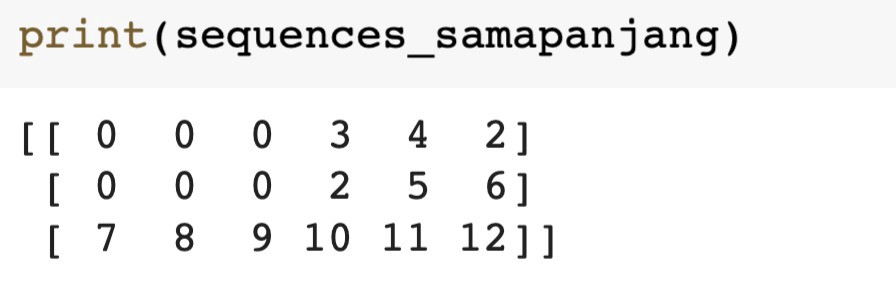

In [12]:
# Apply padding 
x_train = pad_sequences(train)
print(x_train) # Padding Sequences

[[  0   0   0 ...   9 624 625]
 [  0   0   0 ... 263  25  24]
 [  0   0   0 ...  25  19  24]
 ...
 [  0   0   0 ...  78  88  64]
 [  0   0   0 ...  43  16  78]
 [  0   0   0 ...  17  16  78]]


Hasil setelah padding adalah setiap sequence memiliki panjang yang sama. Padding dapat melakukan ini dengan menambahkan 0 secara default pada awal sequence yang lebih pendek.

## **Encoding Text**

Setelah tahapan proses Padding pada suatu teks maka proses terakhir dalam pemrosesan teks adalah tahapan Encoding. **Apa itu Encoding?**

Encoding merupakan suatu konversi atau pengkodean yang dimana data kategorik seperti huruf atau data teks menjadi data numerik atau angka menyesuaikan dengan data label yang digunakan. Pada proses tahapan ini, encoding mengubah data teks pada kolom data tags menjadi data numerik dengan bahasa biner komputer yaitu 0 dan 1. 

Tujuan dari encoding ini adalah mempermudah saat proses komputasi data teks dan modelling.

In [13]:
# Encoding the outputs 
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train) #Label Encodings

[ 68  68  68 ... 186 186 186]


Tokenizer pada Tensorflow memberikan token unik untuk setiap kata yang berbeda. Dan juga padding dilakukan untuk mendapatkan semua data dengan panjang yang sama sehingga dapat mengirimkannya ke lapisan atau layer RNN. variabel target juga dikodekan menjadi nilai desimal.

# **Input Length, Output Length and Vocabulary**

In [14]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

24


In [15]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  914
output length:  241


**Input length** dan **output length** terlihat sangat jelas hasilnya. Mereka adalah untuk bentuk input dan bentuk output dari data train atau latih yang akan diproses pada algoritma Neural Network atau Jaringan Syaraf Tiruan.

**Vocabulary Size** adalah untuk lapisan penyematan untuk membuat representasi vektor unik untuk setiap kata.

## **Save Model Words & Classes**

Setelah dilakukan pemrosesan teks yang dilakukan lima tahap maka kita bisa simpan model pemrosesan teks tersebut dengan menggunakan format pickle. 

Hal ini biasanya digunakan untuk membuat hubungan model yang telah dilatih dengan model pemrosesan teks. 

In [16]:
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

## **Save Label Encoder & Tokenizer**

In [17]:
pickle.dump(le, open('le.pkl','wb'))
pickle.dump(tokenizer, open('tokenizers.pkl','wb'))

In [18]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(50, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [19]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
# Menampilkan Parameter Model
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 10)            9150      
                                                                 
 lstm (LSTM)                 (None, 24, 50)            12200     
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 241)               289441    
                                                                 
Total params: 310,791
Trainable params: 310,791
Non-trainable params: 0
_________________________________________________________________


In [21]:
train = model.fit(x_train, y_train, epochs=50, batch_size=5, verbose=1)

Epoch 1/50
340/340 [==============================] - 5s 7ms/step - loss: 5.2920 - accuracy: 0.0906
Epoch 2/50
340/340 [==============================] - 2s 6ms/step - loss: 4.8170 - accuracy: 0.0965
Epoch 3/50
340/340 [==============================] - 2s 6ms/step - loss: 4.2091 - accuracy: 0.1366
Epoch 4/50
340/340 [==============================] - 2s 7ms/step - loss: 3.4890 - accuracy: 0.2284
Epoch 5/50
340/340 [==============================] - 2s 6ms/step - loss: 2.7144 - accuracy: 0.3690
Epoch 6/50
340/340 [==============================] - 2s 6ms/step - loss: 2.0448 - accuracy: 0.4926
Epoch 7/50
340/340 [==============================] - 2s 6ms/step - loss: 1.5493 - accuracy: 0.6198
Epoch 8/50
340/340 [==============================] - 2s 7ms/step - loss: 1.1686 - accuracy: 0.7116
Epoch 9/50
340/340 [==============================] - 2s 6ms/step - loss: 0.9216 - accuracy: 0.7793
Epoch 10/50
340/340 [==============================] - 2s 6ms/step - loss: 0.7406 - accuracy: 0.8258

# **Model Analysis**

Setelah menjalankan pelatihan model dengan algoritma Neural Network dan LSTM serta telah mengetahui hasil akurasi pada step terakhir. Maka, tahapan selanjutnya adalah menganalisa model dengan visualisasi plot akurasi dan loss untuk melihat hasil akurasi dari algoritma pelatihan model Neural Network dengan LSTM tersebut.

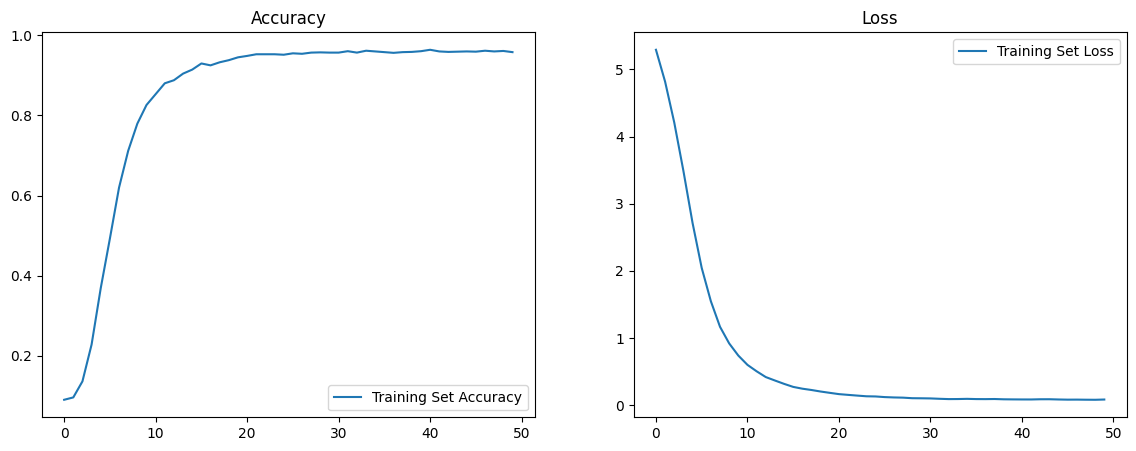

In [22]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [23]:
"""# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model 
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag
  response_tag = le.inverse_transform([output])[0]
  print("🤖 PTABot : ", random.choice(responses[response_tag]))
  # Tambahkan respon 'goodbye' agar bot bisa berhenti
  if response_tag == "goodbye":
    break"""

'# Membuat Input Chat\nwhile True:\n  texts_p = []\n  prediction_input = input(\'👨\u200d🦰 Kamu : \')\n  \n  # Menghapus punktuasi dan konversi ke huruf kecil\n  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]\n  prediction_input = \'\'.join(prediction_input)\n  texts_p.append(prediction_input)\n\n  # Tokenisasi dan Padding\n  prediction_input = tokenizer.texts_to_sequences(texts_p)\n  prediction_input = np.array(prediction_input).reshape(-1)\n  prediction_input = pad_sequences([prediction_input],input_shape)\n\n  # Mendapatkan hasil keluaran pada model \n  output = model.predict(prediction_input)\n  output = output.argmax()\n\n  # Menemukan respon sesuai data tag\n  response_tag = le.inverse_transform([output])[0]\n  print("🤖 PTABot : ", random.choice(responses[response_tag]))\n  # Tambahkan respon \'goodbye\' agar bot bisa berhenti\n  if response_tag == "goodbye":\n    break'

# **Save The Model**

Setelah pengujian Chatbot telah disesuaikan dengan kalimat dan jawabannya. Maka, model chatbot bisa disimpan dengan format .h5 atau .pkl (pickle) untuk penggunaan aplikasi AI Chatbot dengan website atau sistem Android. Penyimpanan file model bisa langsung secara transient atau bisa taruh di Google Drive.

In [24]:
# Simpan model dalam bentuk format file .h5 atau .pkl (pickle)
with open('model_rnn.pkl', 'wb') as doc:
    pickle.dump(model, doc)

doc.close()

print('Model Created Successfully!')


INFO:tensorflow:Assets written to: ram://d197c71b-4ad7-4725-9eae-a83591ea10c6/assets


INFO:tensorflow:Assets written to: ram://d197c71b-4ad7-4725-9eae-a83591ea10c6/assets


Model Created Successfully!
